
# More complex scenarios 

The preceding chapter introduced four different ways of preparing a solution and the forms the backbone of running simulations on World Bank models in `ModelFlow`. This chapter builds on those examples and delves into some of the challenges involved in translating a real-world policy problem into the model-world and then back again.


The particular scenario to be examined is the introduction of a Carbon Tax. The model used, and the example presented are both taken from the model of Pakistan presented in {cite:author}`burns_climate_2021`(2021).

:::{admonition} In this chapter - More Complex Scenarios
:class: tip

This chapter presents some more complex scenarios, and illustrates how to develop a script that introduces changes to the model. 

A complex scenario is developed as deficiencies in initial scenarios are unearthed.  Scenarios presented include:

1) The introduction of a simple carbon tax (a simple shock of an exogenous variable) three exogenous variables in this case.  
2) Upon examining results, it is recognized that the initial nominal shocks loses impact over time because of inflation. Therefore, the shock is re-estimated as an ex-ante real shock (i.e. the initial shock is up-scaled over time in line with inflation to keep its real value constant). 
3) This example is judged imperfect because it does not account for the in-scenario inflation impacts. In a third scenario, the model equations are adjusted so that the ex-post inflation rate is used to maintain the real-value of the Carbon tax. 

The chapter also illustrates how to modify the description of variables in a scenario, and illustrates various techniques for visualizing scenario results. 


:::


In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb   ')


In [2]:
# Prepare the notebook for use of ModelFlow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of ModelFlow outputs
model.widescreen()
model.scroll_off();

No modelwidgets


<IPython.core.display.Javascript object>

In [3]:
# pandas options to make output more legible: 
pd.set_option('display.width', 80)
pd.set_option('display.float_format', '{:.2f}'.format)

## Load a pre-existing model, data and descriptions 

After initializing a `ModelFlow` pandas session in the usual way,  the Pakistan model, which is comprised of the model object, its estimated equations and the data is loaded.  The `pcim` file was created by the World Bank from a slightly modified version of the original EViews model used in the paper ({cite:author}`burns_climate_2021`,2021).  

In [4]:
mpak,bline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep="Baseline")

Zipped file read:  ..\models\pak.pcim


:::{index} single: Carbon tax example(s); simple simulation
:::



## The policy problem

The model object ```mpak``` loaded above contains the model instance, the variables, equations and the data for the model.  On load, the model was solved, and the results of that initial solve was assigned to the `DataFrame` ```bline```. 

The Pakistan model contains three carbon tax variables: 

|Mnemonic | Meaning |
|:--|:--|
|PAKGGREVCO2CER|The effective carbon tax rate on Coal|
|PAKGGREVCO2GER|The effective carbon tax rate on Gas|
|PAKGGREVCO2OER|The effective carbon tax rate on Crude Oil|

As discussed in earlier chapters the meaning of the mnemonics can be retrieved from the model object `mpak`using the `.des` method and a wild-card search.

In [5]:
mpak['PAKGGREVCO2*ER'].des
    

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


Alternatively, one can search on the variable descriptions to retrieve the mnemonics of variables. Below, the exclamation mark (!) at the beginning of the string notifies the matching algorithm to search the variables' descriptions (not the mnemonics) and return all variables that match.


In [6]:
mpak['!*Carbon*'].des

PAKCCEMISCO2TKN : Total Carbon emissions (tons)
PAKGGREVCO2CER  : Carbon tax on coal (USD/t)
PAKGGREVCO2GER  : Carbon tax on gas (USD/t)
PAKGGREVCO2OER  : Carbon tax on oil (USD/t)


Technqiues to query the model object for the meaning of mnemonics or the mnemonics associated with economic concepts are discussed in more detail here: [^selection].

[^selection]: Techniques to identify mnemics that correspond to economic ideas are explored here: {ref}`Variable selection with wildcharts <variable-selection>`   

:::{index} ModelFlow; Dataframe - variable descriptions
:::
:::{index} single: DataFrame; Variable descriptions - set or change
:::


## Add variable descriptions
A `ModelFlow` model imported from `EViews` will inherit the variable descriptors coming from `Eviews`.  The variable descriptors are stored in a dictionary named: `.var_description`. Not all EViews variables will necessarily have a description so additional definitions (descriptions) may need to be provided. 

Below we define a python dictionary in the same format as the dictionary var_description that is contained in the model object `mpak`.  Each dictionary entry is comprised of a key (the variables mnemonic) and a value (the description of the variable).

:::{only} latex
latexcommand \begin{samepage}
:::

In [7]:
extra_description = {'PAKNYGDPMKTPKN': 'GDP',
'EMISCOAL'        : 'Coal emissions',
'EMISGAS'         : 'Gas Emissions',
'EMISOIL'         : 'Gas Emissions',
'PAKCCEMISCO2CKN' : 'Coal emissions, tCO2e',
'PAKCCEMISCO2GKN' : 'Natural Gas emissions, tCO2e',
'PAKCCEMISCO2OKN' : 'Crude Oil emissions, tCO2e',
'PAKCCEMISCO2TKN' : 'Total emissions, tCO2e',
'PAKGGREVEMISCN'  : 'Revenue from emissions taxes',
 'PAKLMUNRTOTLCN': 'Unemployment rate',
 'PAKGGDBTTOTLCN_': 'Debt (%GDP)',
 'PAKGGREVTOTLCN': 'Fiscal revenues',
 'PAKWDL': 'Working days lost due to pollution'}

:::{only} latex
latexcommand \end{samepage}
:::


These new definitions can be merged with the existing description by using the | operator. 

The command 
 > mpak.var_description = mpak.var_description | extra_description

Sets  `mpak.var_description` to a merge between the contents of the dictionary: `mpak.var_description` (its current content) and the dictionary: `extra_description`

Following execution, the `.var_desciption` will be changed to contain both its old values and those added in the extra_description dictionary defined above.

In [ ]:
mpak.var_description = mpak.var_description | extra_description

Several `ModelFlow` methods take advantage of this dictionary to provide more reader-friendly descriptions of variables -- typically through the `rename` option. For those methods that define it, if rename is set to True, the method will substitute the description for the variable name in any outputs.  

Variables with descriptions can also be selected for by using the `mpak['!*subtext*']` syntax, where subtext is some text that appears in the variable descriptor.

## Simulating the impact of imposing a carbon price

To run a simulation, the following steps must invariably be followed.

1. Create a new DataFrame, typically a copy of an existing one.
2. Change the value  in the new df of the variable(s) to be shocked.
3. Solve the model using the newly altered df as the input df.



In [8]:
# Create copy of the bline df
alternative_df = bline.copy()
#set the effective carbon tax of all three carbon tax variables equal to 30 USD
alternative_df.loc[2025:2100,['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER']] = 30 


The above used the `pandas` function `.loc[]` to change the Carbon Tax rate variables.

The `ModelFlow` method `.upd()` could be used to perform the same change. 

:::{index} single: Scenario set up;  use .upd() to initialize shock dataframe
:::
:::{index} ModelFlow; .upd() used to initialize shock dataframe
:::

In [9]:
# This ModelFlow command is equivalent to the previous standard pandas command abive that used the .loc[] syntax
CT30df  =  bline.upd("<2025 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")

:::{index} single: Simulations; Solve the model
:::
:::{index} single: Solve the model 
:::
:::{index} single: Scenarios; Solve the model
:::

### Solve the model

Solving the model is as simple as calling the mpak function with the altered `DataFrame` as an input and assigning the results to a new dataframe (`resultsdf` in this instance).  The `keep` option causes a copy of the dataframe to be stored within the `mpak` model object.

In [10]:
resultsdf = mpak(CT30df,2020,2100,keep="Nominal $30USD Carbon tax") # simulates the model 

:::{Note}
This simulation is a shock on an exogenous variable (the first kind of shock discussed in the previous chapter), although in this case the shock is applied to three exogenous variables simultaneously, whereas in earlier examples only one variable was shocked.
:::

#### Examining the results

Every time the model is solved the results of the simulation are assigned to a variable on the left hand side of the solve call (`resultdf` in the example above).  The results of the most recent scenario are also always stored in the `.lastdf` `DataFrame` that is one of the properties of any `ModelFlow` model object (`mpak` in this case). `basedf` is also a property of `mpak` and contains a copy of the initial DataFrame from which the model was built.

The `bline`,  `.basedf` and the original `.lastdf` `Dataframes` were created when the model was initially loaded and solved. The `resultsdf` database and a revised `.lastdf` were generated when the  model was solved for the new carbon prices.
:::{note}

The standard `dataframes` are part of the `ModelFlow` object and managed by it.

- **mpak.basedf**: `Dataframe` with the values for baseline
- **mpak.lastdf**: `Dataframe` with the values from the most recent simulation
:::


:::{index} single: with clause; .set_smpl(begin,end) method to temporarily alter the active rows in the model object
:::
:::{index} single: ModelFlow; .set_smpl(begin,end) method
:::


The command below shows the results of the simulation on the four emissions variables in the model expressed as a percent deviation from the level of the baseline (the `.difpctlevel` operator below),  and where the mnemonics have been replaced by their descriptions using the `.rename` option.

:::{only} latex
latexcommand \begin{samepage}
:::

In [11]:
with mpak.set_smpl(2023,2030):
    print(mpak['PAKCCEMISCO2*'].difpctlevel.rename().df);

      PAKCCEMISCO2CKN  PAKCCEMISCO2GKN  PAKCCEMISCO2OKN  \
2023             0.00             0.00             0.00   
2024             0.00             0.00             0.00   
2025           -41.19           -26.99           -10.93   
2026           -40.06           -25.72           -10.98   
2027           -38.85           -24.48           -10.89   
2028           -37.59           -23.30           -10.68   
2029           -36.26           -22.14           -10.35   
2030           -34.89           -21.01            -9.95   

      Total Carbon emissions (tons)  
2023                           0.00  
2024                           0.00  
2025                         -22.17  
2026                         -21.56  
2027                         -20.89  
2028                         -20.17  
2029                         -19.38  
2030                         -18.55  


:::{only} latex
latexcommand \end{samepage}
:::


The impact of the imposition of the carbon tax in the model is relatively quick, resulting in an overall decline in emissions of 22.2% in the first year, with coal emissions (coal is a relatively carbon intensive source of energy so harder hit by the carbon tax) recording the biggest hit at -41.2 percent.


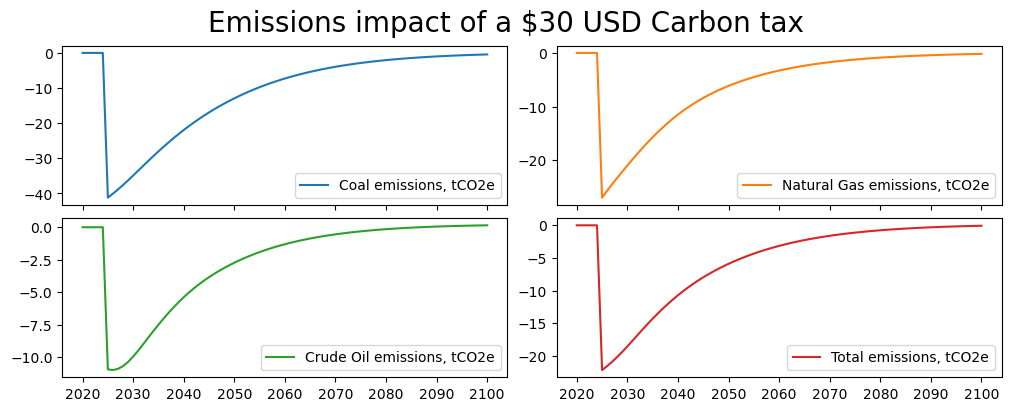

In [13]:
mpak['PAKCCEMISCO2?KN'].difpctlevel.rename().plot(title="Emissions impact of a $30 USD Carbon tax");


Abstracting from the fact that the impact is occurring too quickly (it would take time for the substitution towards alternative sources of power to occur), the fact that impacts are fading with time suggests an error in the specification of the shock. 

Indeed, high domestic inflation means that the real price change of the $30 nominal increase in the Carbon price is declining over time -- suggesting that the scenario needs tweaking.

## Re-thinking the shock as an ex-ante real shock

Inflation in Pakistan is relatively high so a $30 shock quickly loses its relative price effect. Increasing the nominal value of the Carbon Tax by the amount of domestic inflation (converted into USD each year) would resolve the problem. 

Below a new `DataFrame` is created as a copy of the baseline and the three Carbon taxes are first set to $30 in 2025 and then grown at the rate of domestic inflation to keep the **ex ante** relative price of the Carbon Tax constant.

Finally the model is re-solved.

:::{index} single: Scenarios;  use .mfcalc() to initialize shocked dataframe
:::
:::{index} single: Simulations;  use .mfcalc() to initialize shocked dataframe
:::
:::{index} mfcalc(); to initialize shocked dataframe
:::

In [14]:

CT30realdf  =  bline.copy()
CT30realdf=CT30realdf.upd("<2025 2025> PAKGGREVCO2CER PAKGGREVCO2OER PAKGGREVCO2GER = 30")

#NB: Variables used 
#   PAKNECONPRVTXN is the consumer price deflator
#   PAKPANUSATLS id the USD exchange rate
CT30realdf=CT30realdf.mfcalc('''
                              <2026 2100> PAKGGREVCO2CER = PAKGGREVCO2CER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1))
                                      PAKGGREVCO2OER = PAKGGREVCO2OER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1))
                                      PAKGGREVCO2GER = PAKGGREVCO2CER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1))
                          ''')                         

CT30realdf.loc[2023:2030,'PAKGGREVCO2CER']


resultsdf = mpak(CT30realdf,2020,2100,keep="Ex ante Real $30USD Carbon tax") # simulates the model 


The above code first sets the Carbon prices to 30USD and then  grows them at the same rate as inflation.  Below we see that with inflation of 30% per annum the domestic carbon price is rising rapidly.

In [15]:
with mpak.set_smpl(2023,2030):
    print(mpak['PAKGG*ER'].rename().df)

      Carbon tax on coal (USD/t)  Carbon tax on gas (USD/t)  \
2023                       -5.55                     -41.00   
2024                       -5.55                     -41.00   
2025                       30.00                      30.00   
2026                       31.83                      31.83   
2027                       33.64                      33.64   
2028                       35.45                      35.45   
2029                       37.26                      37.26   
2030                       39.09                      39.09   

      Carbon tax on oil (USD/t)  
2023                      -8.71  
2024                      -8.71  
2025                      30.00  
2026                      31.83  
2027                      33.64  
2028                      35.45  
2029                      37.26  
2030                      39.09  


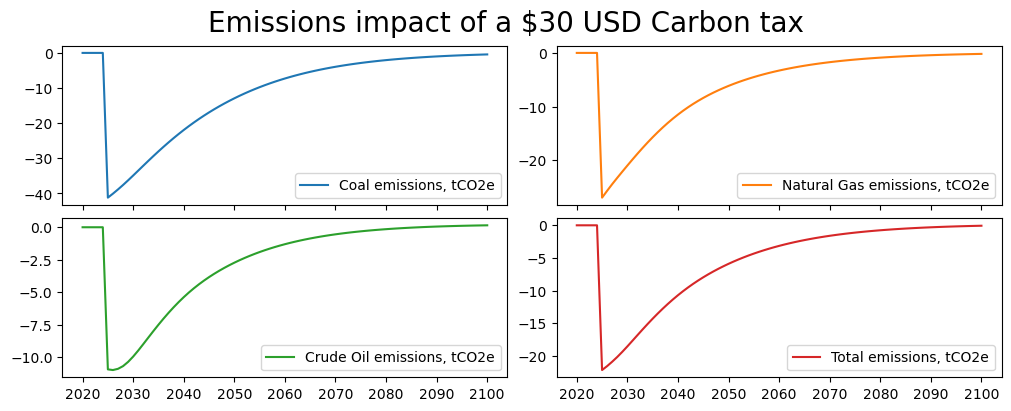

In [15]:

mpak['PAKCCEMISCO2?KN'].difpctlevel.rename().plot(title="Emissions impact of a $30 USD Carbon tax");


These results are better, but still there is an erosion of the effect of the tax.


On introspection, this is likely due to the fact that the carbon tax itself is inflationary.  As a result, prices probably rose to a higher level than supposed by the ex ante calculation.

To deal with this, a different approach is needed.  Rather than maintaining the carbon price as an exogenous variable, instead it should be made an endogenous variable by changing the model and adding equations for all of the carbon tax variables.

Before doing so lets save the current version of the model for further work later.

In [16]:
mpak.modeldump('../models/pakCarbonTaxScenarios.pcim')

:::{index} single: Carbon tax example(s); Complex simulations
:::
:::{index} single: Simulations; Changing equations
:::
:::{index} single: Scenarios; Changing equations
:::
:::{index} single: Revising model equations
:::
:::{index} single: Equations; .equpdate() Revising model equations
:::

## Changing the model -- modifying and or adding equations

To endogenize the carbon price, an equation for each carbon price has to be added to the model.   This can be done with the `.equpdate()` method.  

In [17]:
#Reload original model and data
mpak1,bline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep="Baseline")


#Create a new model object mpakreal and new baseline dataframe-- baselinereal 
#The nominal carbon taxes (expressed in USD) are now endogenous 
#and increase with domestic inflation and the exchange rate

mpakreal,blinereal = mpak1.equpdate('''
<fixable> PAKGGREVCO2CER = PAKGGREVCO2CER(-1) * (PAKNYGDPMKTPXN*PAKPANUSATLS) / (PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1))
<fixable> PAKGGREVCO2OER = PAKGGREVCO2OER(-1) * (PAKNYGDPMKTPXN*PAKPANUSATLS) / (PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1))
<fixable> PAKGGREVCO2GER = PAKGGREVCO2GER(-1) * (PAKNYGDPMKTPXN*PAKPANUSATLS) / (PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1))
''',add_add_factor=False, calc_add=False,newname='Pak model, with real Carbon price equations')


Zipped file read:  ..\models\pak.pcim

The model:"PAK" got new equations, new model name is:"Pak model, with real Carbon price equations"
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2CER = (PAKGGREVCO2CER(-1)*(PAKNYGDPMKTPXN*PAKPANUSATLS)/(PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2CER_D)+ PAKGGREVCO2CER_X*PAKGGREVCO2CER_D$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2OER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2OER = (PAKGGREVCO2OER(-1)*(PAKNYGDPMKTPXN*PAKPANUSATLS)/(PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2OER_D)+ PAKGGREVCO2OER_X*PAKGGREVCO2OER_D$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2GER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2GER = (PAKGGREVCO2GER(-1)*(PAKNYGDPMKTPXN*PAKPANUSATLS)/(PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2GER_D)+ PAKGGREVCO2GER_X

As written, the `.equpdate()` command creates a new model, which is a copy of the existing model with three new equations.

Each equation grows the nominal rate of the carbon tax at the same rate as *ex post* inflation (`PAKNECONPRVTXN`) converted into USD via the exchange rate `PAKPANUSATLS`. The equations are introduced as exogenizable equations (as distinct from an identity which must always hold) by adding the \<fixable\> prefix to each equation. The equations are not estimated, so no add-factors are included in the equations.

The output for the `.equpdate()` reports the actual formulae included in the model. 
```
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2CER = (PAKGGREVCO2CER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2CER_D)+ PAKGGREVCO2CER_X*PAKGGREVCO2CER_D$
Adjust calc:No frml for adjustment calc 
```
Note that because the equations are to be fixable, an \_X and \_D variable are added to the specified equations. Combined they effectively split each equation into  two:
1. the specified equations when \_D equals zero
2. equal to \_X when the \_D equals one.

The newly created model is given the name mpakreal and is given a text description.

Following the addition of the equations, the new variables (\_D and \_X) must be initialized. The \_X variables are made equal to the current values of the various tax rates, while the \_D is set to 1 everywhere -- effectively turning the equation off and re-creating the same situation as the initial model where the tax rates are fully exogenous.

As with the `mpak` model the variable descriptions need to be updated. 

In [19]:
mpakreal.var_description = mpakreal.var_description | extra_description

:::{index} single: ModelFlow; .equpdate() - revising model equations 
:::
:::{index} single: Revising model equations; .equpdate() 
:::
:::{index} single: Model equations; Revise equations with .equpdate() 
:::


In [18]:
#Exogenizes the newly added equations and sets the dummy =1 amd the _x to the current value of the dependent variable  
bline_real=mpakreal.fix(blinereal,'PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER')


The folowing variables are fixed
PAKGGREVCO2CER
PAKGGREVCO2GER
PAKGGREVCO2OER


Finally the new model is solved, the result is kept in a new baseline and a quick check ensures that the model did indeed reproduce the data that it was originally fed, including the initial Carbon Tax levels.

In [19]:

#Solve the model for the new baseline
res = mpakreal(bline_real,2021,2100,alfa=0.5,keep='Baseline - adjusted model') 

mpakreal['PAKNYGDPMKTPKN PAKNECONPRVTXN PAKGGBALOVRL PAKGGREVCO2CER PAKCCEMISCO2TKN'].difpctlevel.rename().df

,Real GDP,"Implicit LCU defl., Pvt. Cons., 2000 = 1",Carbon tax on coal (USD/t),Total Carbon emissions (tons)
2021,0.00,0.00,-0.00,0.00
2022,0.00,0.00,-0.00,0.00
2023,0.00,0.00,-0.00,0.00
2024,0.00,0.00,-0.00,0.00
2025,0.00,0.00,-0.00,0.00
...,...,...,...,...
2096,0.00,0.00,-0.00,0.00
2097,0.00,0.00,-0.00,0.00
2098,0.00,0.00,-0.00,0.00
2099,0.00,0.00,-0.00,0.00


### Solving the revised model

With the new model generated, it can now be solved with the real tax rate endogenized in the forecast period.  This involves three steps.

1. Set the nominal tax rate to 30 in 2025
2. Now Endogenize the equation for the rest of the period
3. Solve the model.


In [20]:
scenario_real_CTax = bline_real.upd('''
<2025 2025> 
PAKGGREVCO2CER_X PAKGGREVCO2GER_X PAKGGREVCO2OER_X = 30 # Sets the exogenous value to 30 in 2025
<2026 2100 > 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_D = 0   # Endogenizes the new equations for the rest of time so that the real-rate stays at 30USD
''')


_ = mpakreal(scenario_real_CTax,2021,2100,alfa=0.5,keep='Real model real tax = 30 at 2025 prices and exchange  rates')





Initially the Carbon tax comes in at 30 but gradually its rate in USD rises in line with inflation such that it reaches $1358 by 2100.  

In [21]:

mpakreal['PAKGGREVCO2?ER PAKNECONPRVTXN PAKNYGDPMKTPXN '].rename().df

,Carbon tax on coal (USD/t),Carbon tax on gas (USD/t),Carbon tax on oil (USD/t),"Implicit LCU defl., Pvt. Cons., 2000 = 1","GDP, Marker Prices, LCU Price defl., 2000 = 1"
2021,-5.55,-41.00,-8.71,1.82,1.95
2022,-5.55,-41.00,-8.71,1.98,2.14
2023,-5.55,-41.00,-8.71,2.14,2.32
2024,-5.55,-41.00,-8.71,2.30,2.50
2025,30.00,30.00,30.00,2.51,2.72
...,...,...,...,...,...
2096,1098.50,1098.50,1098.50,106.62,112.39
2097,1158.34,1158.34,1158.34,112.69,118.75
2098,1221.44,1221.44,1221.44,119.11,125.47
2099,1287.97,1287.97,1287.97,125.89,132.58


This seemingly very high level is just a reflection of the 75 years of inflation that compounded require a much higher nominal Carbon tax rate to have the same relative price effect. The cumulative effect of inflation in the range of 5.5 real  per annum causes the price level to increase 74 times (7400 percent increase  133/1.8 from fourth data column in the above table).  

The table below shows the same data but in growth rate terms -- indicating that the nominal Carbon tax rate is gradually rising each year in line domestic inflation adjusted for the exchange rate -- i.e. it is constant in real terms.

In [22]:
mpakreal['PAKGGREVCO2?ER PAKPANUSATLS PAKNYGDPMKTPXN'].pct.rename().df

,Carbon tax on coal (USD/t),Carbon tax on gas (USD/t),Carbon tax on oil (USD/t),Exchange rate LCU / US$ - Pakistan,"GDP, Marker Prices, LCU Price defl., 2000 = 1"
2021,0.00,0.00,0.00,-0.16,10.69
2022,0.00,0.00,0.00,-0.16,9.76
2023,0.00,0.00,0.00,-0.14,8.71
2024,0.00,0.00,0.00,-0.12,7.76
2025,-640.56,-173.17,-444.41,-0.30,8.90
...,...,...,...,...,...
2096,5.45,5.45,5.45,-0.20,5.66
2097,5.45,5.45,5.45,-0.20,5.66
2098,5.45,5.45,5.45,-0.20,5.66
2099,5.45,5.45,5.45,-0.20,5.66


### Results

The results from the simulation with the Carbon Tax rate endogenized so as to maintain its real value over time, are broadly consistent with the results from the ex ante real scenario performed above.



In [23]:

mpakreal['PAKCCEMISCO2?KN'].difpctlevel.rename().df

,PAKCCEMISCO2CKN,PAKCCEMISCO2GKN,PAKCCEMISCO2OKN,Total Carbon emissions (tons)
2021,0.00,0.00,0.00,0.00
2022,0.00,0.00,0.00,0.00
2023,0.00,0.00,0.00,0.00
2024,0.00,0.00,0.00,0.00
2025,-41.19,-26.99,-10.93,-22.17
...,...,...,...,...
2096,-24.23,-10.33,-5.30,-10.85
2097,-24.09,-10.25,-5.25,-10.78
2098,-23.95,-10.18,-5.20,-10.70
2099,-23.81,-10.11,-5.15,-10.63


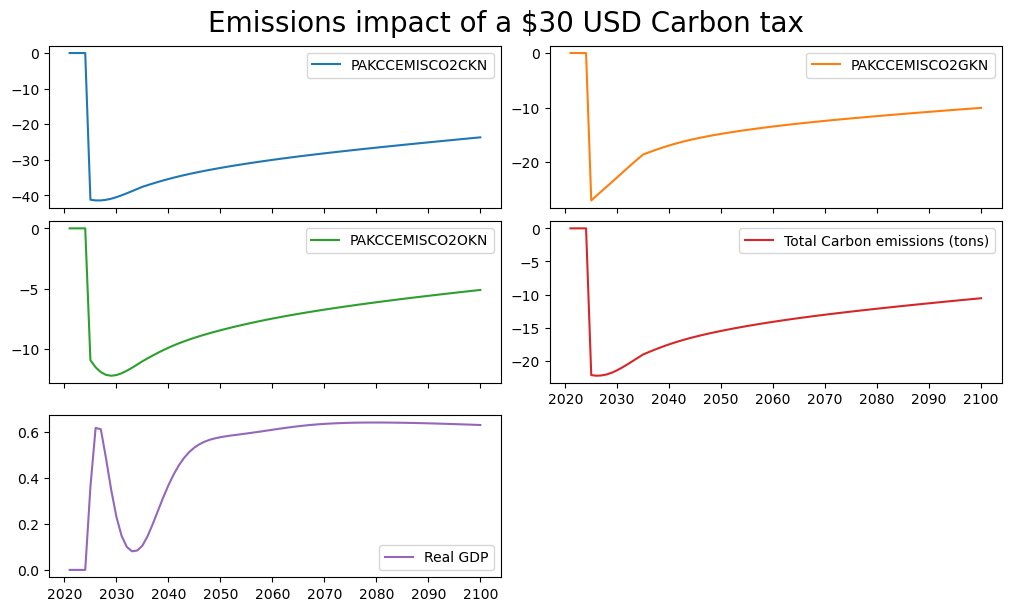

In [24]:
(mpakreal['PAKCCEMISCO2?KN PAKNYGDPMKTPKN'].difpctlevel.
 rename().plot(title="Emissions impact of a constant real $30 USD Carbon tax"));

The modified model, which preserves the real value of the carbon tax has a permanent and substantial negative effect on emissions. The impact is not at an unchanging level, reflecting in part adaptation within the economy. Of particular import is what is being done with the revenues from the Carbon tax. As the structure of GDP (shifts to less carbon intensive activities) carbon tax revenues fall even as the Carbon Tax rate rises. 

Note, the percent deviation of emissions tends to decrease over time in this scenario principally because the level of activity (GDP) is higher with the Carbon Tax than without it. As a result,  emissions are higher than they would have been had GDP remained unchanged. For the Pakistan model, the positive impact of the Carbon tax is mainly explained by co-benefits, notably reduced reliance on more distortionary taxes such as payroll taxes and because of reductions in informality and due to health and productivity benefits from lower pollution levels (see {cite:author}`burns_climate_2021`(2021) for more details how these effects operate in the Pakistan model).
